In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr

# Extrapolation in temperature

In [2]:
#Import idealgas module
from thermoextrap import idealgas

#Define test betas and reference beta
betas = np.arange(0.1, 10.0, 0.5)
beta_ref = betas[11]
vol = 1.0

#Define orders to extrapolate to
orders = [1,2,4,6]
order = orders[-1]

npart = 1000 #Number of particles (in single configuration)
nconfig = 100_000 #Number of configurations

#Generate all the data we could want
xdata, udata = idealgas.generate_data((nconfig, npart), beta_ref, vol)

## Case 4: Observable is the negative logarithm of an average with explicit temperature dependence

Comparing to Cases 1-3, it should be clear that this is possible and only slightly more annoying to implement. This will come up any time you have computed a free energy change, such as solvation, via exponential averaging at one temperature and want to extrapolate it to another temperature. Note that free energy differences calculated by any method at a given temperature may also be extrapolated using differences in moments of the potential energies between the beginning and end states along the thermodynamic path. This may be more efficient, but has not been investigated.

As in Case 2, we will need to augment the data with information about the explicit derivatives of the observable with respect to the extrapolation variable.

In [3]:
import thermoextrap as xtrap

In [4]:
# You can use numpy and just wrap with xarray after...
xdataDepend = np.array([xdata*beta_ref, xdata])
xdataDepend = np.vstack((xdataDepend, np.zeros((orders[-1] - 1, xdata.shape[0]))))
xdata = xr.DataArray(xdata, dims=['rec'])
udata = xr.DataArray(udata, dims=['rec'])
#Note the naming of dimensions here and see "Data_Organization" for a full explanation
xdataDepend = xr.DataArray(xdataDepend, dims=['deriv', 'rec'], coords={'deriv':np.arange(xdataDepend.shape[0])})

# # Or you can accomplish this with xarray if you really want to...
# xdata = xr.DataArray(xdata, dims=['rec'])
# udata = xr.DataArray(udata, dims=['rec'])
# xdataDepend = (
#     xr.concat([xdata*beta_ref, xdata], dim='deriv')
#     .assign_coords(deriv=lambda x: np.arange(x.sizes['deriv']))
#     .reindex(deriv=np.arange(orders[-1] + 1))
#     .fillna(0.0)
# )

In [5]:
#Create and train extrapolation model
xem_log_dep = xtrap.beta.factory_extrapmodel(
    beta=beta_ref, post_func='minus_log',
    data=xtrap.DataCentralMomentsVals.from_vals(order=orders[-1], 
                                              xv=xdataDepend, 
                                              uv=udata, 
                                              central=True, 
                                              deriv_dim='deriv'))

#Note that we handled the -log calculation in the definition of the derivatives (even at zeroth order).
#This means we want to just pass data, not the -log of the data.

#Check the parameters
print("Model parameters (derivatives):")
print(xem_log_dep.derivs(norm=False))
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(xem_log_dep.predict(betas[:4], order=2))
print('\n')

Model parameters (derivatives):
<xarray.DataArray (order: 7)>
array([ 2.09812143e-02, -1.81297299e-02,  1.20779523e-02,  8.39681267e-02,
       -9.83478999e-01,  1.02767536e+01,  8.87249700e+01])
Dimensions without coordinates: order


Model predictions:
<xarray.DataArray (beta: 4)>
array([0.30337376, 0.26260427, 0.22485427, 0.19012375])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6




In [6]:
xem_log_dep.resample(nrep=100).predict(betas[:4], order=2).std('rep')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<xarray.DataArray (beta: 4)>
array([0.10843181, 0.08965355, 0.0726607 , 0.05745324])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6

True extrapolation coefficients: [ 0.02100394 -0.01751449  0.01416089 -0.01102172  0.00821238 -0.00589552
  0.00429019]
	 With N_configs =     10: [ 3.20052577e-02 -7.38241962e-02  5.62029898e-01  1.56634829e+00
 -2.81134574e+01 -6.74634825e+02 -4.68187580e+03]
	 With N_configs =    100: [ 2.03604558e-02 -3.18874616e-02 -1.77024152e-01  4.78563507e+00
 -1.67635356e+01 -4.13017649e+02  7.96248624e+03]
	 With N_configs =   1000: [ 1.99972847e-02 -2.21080132e-02  5.47084652e-04  7.55939788e-01
  4.42103627e+00  2.69697059e+01  1.39170821e+03]
	 With N_configs =  10000: [ 2.06966737e-02 -2.01627639e-02  1.19482743e-02  2.19774706e-01
 -3.32683267e+00  4.74919718e+01 -3.90127530e+02]
	 With N_configs = 100000: [ 2.09812143e-02 -1.81297299e-02  1.20779523e-02  8.39681267e-02
 -9.83478999e-01  1.02767536e+01  8.87249700e+01]


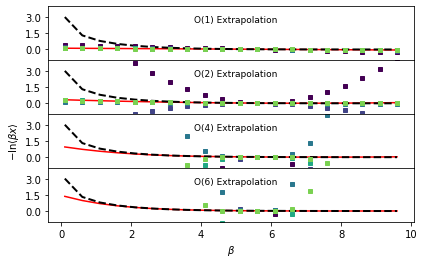

In [7]:
#Repeat comparison of results, but for -ln<B*x>, the most complicated case

fig, ax = plt.subplots(len(orders), sharex=True, sharey=True)

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betas, -np.log(betas* idealgas.x_ave(betas, vol)), 'k--', linewidth=2.0)

#Next look at extrapolation with an infinite number of samples
#This is possible in the ideal gas model in both temperature and volume
for j, o in enumerate(orders):
    trueExtrap, trueDerivs = idealgas.x_beta_extrap_depend_minuslog(o, beta_ref, betas, vol)
    ax[j].plot(betas, trueExtrap, 'r-', zorder=0)
    if j == len(orders)-1:
        print('True extrapolation coefficients: {}'.format(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    xem_log_dep = xtrap.beta.factory_extrapmodel(
        beta=beta_ref, post_func='minus_log',
        data=xtrap.DataCentralMomentsVals.from_vals(order=orders[-1], 
                                                  uv=udata[thisinds], 
                                                  xv=xdataDepend.sel(rec=thisinds), 
                                                  deriv_dim='deriv',
                                                  central=True))
    out = xem_log_dep.predict(betas, cumsum=True)
    print('\t With N_configs = %6i: %s'%(n, str(xem_log_dep.derivs(norm=False).values.flatten()))) #Have to flatten because observable is 1-D
    for j, o in enumerate(orders):
        out.sel(order=o).plot(marker='s', ms=4, color=nsampcolors[i], ls='None', label='N={}'.format(n), 
                              ax=ax[j])

ax[2].set_ylabel(r'$-\mathrm{ln} \langle \beta x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

for j, o in enumerate(orders):
    ax[j].annotate('O(%i) Extrapolation'%(o), xy=(0.4, 0.7), xycoords='axes fraction', fontsize=9)

ax[0].set_ylim((-1.0, 4.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

for a in ax:
    a.set_title(None)

plt.show()
